In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_df(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    return df

def get_val_loss(df):
    return df.val_or_test_loss.values[-1]

def get_last_epoch(df):
    return df.iloc[-1]

In [3]:
def get_learned_hyperparameters(experiments_path, lr_0s, ns, prior_scales, random_states, weight_decays):
    columns = ['lr_0', 'n', 'prior_scale', 'random_state', 'weight_decay']
    df = pd.DataFrame(columns=columns)
    for n, prior_scale, random_state in itertools.product(ns, prior_scales, random_states):
        best_val_loss = np.inf
        best_hyperparameters = None
        for lr_0, weight_decay in itertools.product(lr_0s, weight_decays):
            model_name = 'learned_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
            .format(lr_0, n, prior_scale, random_state, weight_decay)
            path =  '{}/{}.csv'.format(experiments_path, model_name)
            val_loss = get_val_loss(get_df(path))
            if val_loss < best_val_loss: best_val_loss = val_loss; best_hyperparameters = [lr_0, n, prior_scale, random_state, weight_decay]
        df.loc[df.shape[0]] = best_hyperparameters
    return df

def get_learned_results(df, experiments_path):
    columns = ['n', 'prior_scale', 'random_state', 'method', 'test_acc', 'test_loss', 'test_nll', 
           'test_prior', 'train_acc', 'train_loss', 'train_nll', 'train_prior']
    results = pd.DataFrame(columns=columns)
    for row_index, row in df.iterrows():
        model_name = 'learned_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
        .format(row.lr_0, int(row.n), row.prior_scale, int(row.random_state), row.weight_decay)
        path =  '{}/{}.csv'.format(experiments_path, model_name)
        last_epoch = get_last_epoch(get_df(path))
        results_row = [int(row.n), row.prior_scale, int(row.random_state), 'learned', 
                       last_epoch.val_or_test_acc, last_epoch.val_or_test_loss, 
                       last_epoch.val_or_test_nll, last_epoch.val_or_test_prior, 
                       last_epoch.train_acc, last_epoch.train_loss, 
                       last_epoch.train_nll, last_epoch.train_prior]
        results.loc[results.shape[0]] = results_row
    return results

In [12]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = np.logspace(-1, -4, num=4)
ns = [1000]
prior_scales = np.logspace(0, 9, num=10)
random_states = [1001, 2001, 3001]
weight_decays = np.append(np.logspace(-2, -6, num=5), 0)
learned_hyperparameters = get_learned_hyperparameters(experiments_path, lr_0s, ns, prior_scales, random_states, weight_decays)
learned_hyperparameters

,lr_0,n,prior_scale,random_state,weight_decay
0,0.0100,1000.0,1.000000e+00,1001.0,0.000001
1,0.0100,1000.0,1.000000e+00,2001.0,0.000010
2,0.0100,1000.0,1.000000e+00,3001.0,0.000010
3,0.0100,1000.0,1.000000e+01,1001.0,0.000010
4,0.0100,1000.0,1.000000e+01,2001.0,0.000010
5,0.0100,1000.0,1.000000e+01,3001.0,0.000010
6,0.0100,1000.0,1.000000e+02,1001.0,0.000001
7,0.0100,1000.0,1.000000e+02,2001.0,0.000010
8,0.0100,1000.0,1.000000e+02,3001.0,0.000001
9,0.0100,1000.0,1.000000e+03,1001.0,0.000010


In [13]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
count = -1
for row_index, row in learned_hyperparameters.iterrows():
    model_name = 'learned_lr_0={}_n={}_prior_scale={}_random_state={}_weight_decay={}'\
    .format(row.lr_0, int(row.n), row.prior_scale, int(row.random_state), row.weight_decay)
    if not os.path.exists('{}/{}.csv'.format(experiments_path, model_name)):
        count += 1
        print('    "python ../src/CIFAR10_main.py --dataset_path=\'{}\' --experiments_path=\'{}\' --learned_prior --lr_0={} --model_name=\'{}\' --n={} --prior_path=\'{}\' --prior_scale={} --random_state={} --wandb --weight_decay={}"'\
              .format(dataset_path, experiments_path, row.lr_0, model_name, int(row.n), prior_path, row.prior_scale, int(row.random_state), row.weight_decay))
print(count)

-1


In [14]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
results = get_learned_results(learned_hyperparameters, experiments_path)
results

,n,prior_scale,random_state,method,test_acc,test_loss,test_nll,test_prior,train_acc,train_loss,train_nll,train_prior
0,1000,1.000000e+00,1001,learned,0.845622,-544.478714,0.547040,545.025757,1.000000,-5450.257211,0.000226,5450.257324
1,1000,1.000000e+00,2001,learned,0.837374,-544.432737,0.593141,545.025879,1.000000,-5450.258238,0.000228,5450.258301
2,1000,1.000000e+00,3001,learned,0.855780,-544.515789,0.509299,545.025085,1.000000,-5450.250676,0.000248,5450.250977
3,1000,1.000000e+01,1001,learned,0.842462,-537.956924,0.564928,538.521851,1.000000,-5385.218023,0.000232,5385.218262
4,1000,1.000000e+01,2001,learned,0.839819,-537.954260,0.567470,538.521729,1.000000,-5385.217160,0.000233,5385.217285
5,1000,1.000000e+01,3001,learned,0.842855,-537.946979,0.574873,538.521851,1.000000,-5385.218199,0.000224,5385.218262
6,1000,1.000000e+02,1001,learned,0.844788,-492.721414,0.567130,493.288544,1.000000,-4932.885742,0.000210,4932.885742
7,1000,1.000000e+02,2001,learned,0.840478,-492.710398,0.577993,493.288391,1.000000,-4932.883727,0.000220,4932.883789
8,1000,1.000000e+02,3001,learned,0.849612,-492.746409,0.541890,493.288300,1.000000,-4932.882688,0.000234,4932.882812
9,1000,1.000000e+03,1001,learned,0.848854,-165.373818,0.524345,165.898163,1.000000,-1658.981370,0.000191,1658.981567


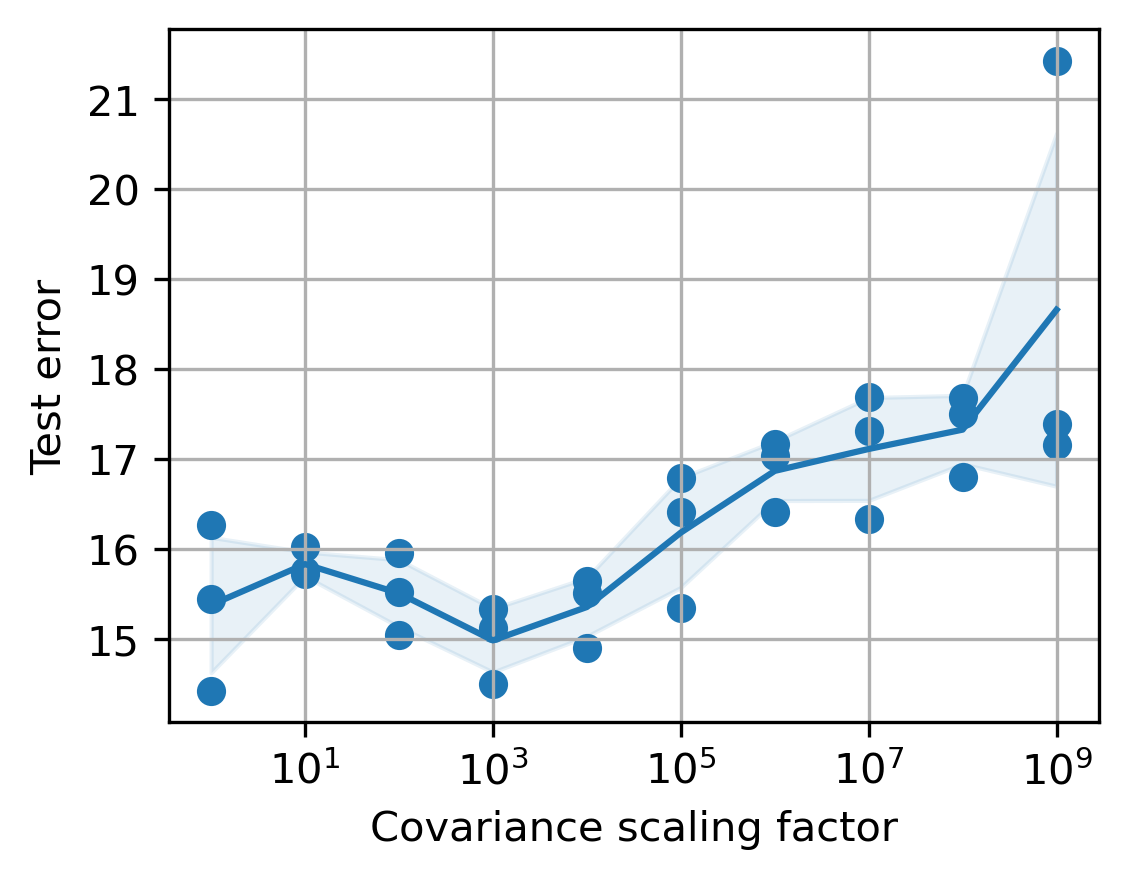

In [15]:
# TODO: If more seeds are added average over seeds
grouped_results = results.groupby(['n', 'prior_scale', 'method']).agg(lambda x: tuple(x))
columns = ['test_acc', 'train_acc']
for column in columns:
    grouped_results['{}_mean'.format(column)] = grouped_results[column].apply(lambda item: np.mean(item))
    grouped_results['{}_std'.format(column)] = grouped_results[column].apply(lambda item: np.std(item))
grouped_results = grouped_results.reset_index()

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3), dpi=300)
ax.plot(grouped_results.prior_scale, 100*(1-grouped_results.test_acc_mean), color='#1f77b4')
ax.scatter(results.prior_scale, 100*(1-results.test_acc), color='#1f77b4')
ax.fill_between(grouped_results.prior_scale, 100*(1-grouped_results.test_acc_mean-grouped_results.test_acc_std), 100*(1-grouped_results.test_acc_mean+grouped_results.test_acc_std), color='#1f77b4', alpha=0.1)
ax.set_xscale('log')
ax.set_xlabel('Covariance scaling factor')
ax.set_ylabel('Test error')
ax.grid()